In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class LSB_Embed():
    
    def __init__(self):
        pass
    
    @staticmethod
    def get_bitPlane(img):
        h, w, c = img.shape
        bitPlane = np.zeros(shape=(h,w,8,c))
        for c_i in range(c):
            flag = 0b00000001
            for bit_i in range(bitPlane.shape[-2]):
                bp = img[...,c_i] & flag
                bp[bp != 0] = 1 # 阈值处理 非0即1
                bitPlane[..., bit_i, c_i] = bp # 处理后的数据载入到某个位平面
                flag <<= 1 # 获取下一位信息
                
        return bitPlane.astype(np.uint8)
        
    @staticmethod
    def lsb_embed(background, watermark, embed_bit):
        """
        在background的低n位进行嵌入水印，具体为将watermark的高n位信息替换掉background的低n位信息
        :param background: 背景图像（彩色）
        :param watermark: 水印图像（彩色）
        :return: 嵌入水印的图像
        """
        # 判断是否满足可嵌入条件 水印的尺寸要小于背景的尺寸
        w_h, w_w, w_c = watermark.shape # 长 宽 通道数
        b_h, b_w, b_c = background.shape
        assert w_w < b_w and w_h < b_h, "水印的尺寸要小于背景的尺寸,当前水印尺寸{},背景尺寸{}".format(watermark.shape, background.shape)
        
        # 获取位平面
        # RGB通道 从小到大 (0 1 2 3 4 5 6 7 8)
        bitPlane_background = LSB_Embed.get_bitPlane(background)
        print(bitPlane_background.shape)
        bitPlane_watermark = LSB_Embed.get_bitPlane(watermark)
        
        # 在位平面嵌入信息
        for c_i in range(b_c):
            for i in range(embed_bit):
                bitPlane_background[0:w_h, 0:w_w, i, c_i] = bitPlane_watermark[0:w_h, 0:w_w, (8 - embed_bit) + i, c_i]
        
        # 得到水印嵌入图像
        embed_image = np.zeros_like(background)
        for c_i in range(b_c): # 每个通道
            for i in range(8):
                embed_image[..., c_i] += bitPlane_background[..., i, c_i] * np.power(2, i)
                
        print(embed_image[..., 2])
        print(bitPlane_background[..., 1, 2])
        
        return embed_image.astype(np.uint8)
    
    @staticmethod
    def lsb_extract(embed_image, embed_bit):
        """
        从图像中获取嵌入的水印
        :param embed_image 带有水印的图像
        :param embed_bit 水印所处的位层
        :return 水印图像和背景图像
        """
        bitPlane = LSB_Embed.get_bitPlane(embed_image)
        extract_watermark = np.zeros_like(embed_image)
        extract_background = np.zeros_like(embed_image)
        # 三通道
        for c_i in range(3):
            for i in range(8):
                if i < embed_bit:
                    extract_watermark[..., c_i] += bitPlane[..., i, c_i] * np.power(2, (8 - embed_bit) + i)
                else:
                    extract_background[..., c_i] += bitPlane[..., i, c_i] * np.power(2, i)
        return extract_watermark.astype(np.uint8), extract_background.astype(np.uint8)

(640, 640, 8, 3)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


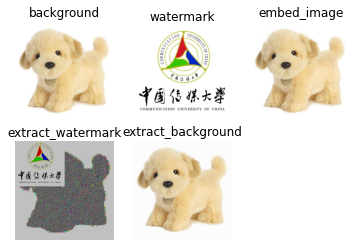

In [15]:
if __name__ == '__main__':
    
    lsb = LSB_Embed()
    
    # 获取背景和水印图片
    background = cv2.imread("./dog.png")
    watermark = cv2.imread("./watermark.png")
    
    # opencv默认的彩色图像的颜色空间是BGR
    background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
    watermark = cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB)    
    
    # 备份原始图像
    background_backup = background.copy()
    watermark_backup = watermark.copy()
    
    # 水印嵌入
    embed_bit = 2 # 参数 嵌入的图像位平面
    embed_image = lsb.lsb_embed(background, watermark, embed_bit)
    
    # 水印提取
    extract_watermark, extract_background = lsb.lsb_extract(embed_image, embed_bit)
    
    # 结果展示
    imgs = [background_backup, watermark_backup, embed_image, extract_watermark, extract_background]
    title = ["background", "watermark", "embed_image", "extract_watermark", "extract_background"]
    for i in range(len(imgs)):
        plt.subplot(2, 3, i + 1);
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.title(title[i])
    plt.show()